# Exploratory Data Analysis 
## MLB Statistics by Team - Current Season

This notebook documents an Exploratory Data Analysis of MLB statistics to be analyzed using machine learning techniques in an effort to predict game outcomes. This analysis seeks to visualize the data in order to provide key insights in terms of potential predictive features and relationships that can be used in machine learning models. 

The following code cell adds the root directory of the project to Python's `sys.path` in order to access modules from different directory levels.

In [32]:
import sys
from pathlib import Path

notebook_module = Path.cwd()
project_root = notebook_module.parent.parent.parent
sys.path.append(str(project_root))

The next code cell allows the notebook to access and load environment variables that are required for configuring and connecting to the database.

In [33]:
from dotenv import load_dotenv

dotenv_path = project_root / 'api/.env'
load_dotenv(dotenv_path)

True

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from shared.database import connect_to_db
from machine_learning.data.models.mlb_models import MLBTeam, MLBOffensiveStats, MLBDefensiveStats, MLBSchedule

In [35]:
session = connect_to_db()

teams_df = pd.read_sql_table('mlb_teams', session.bind)
offensive_stats_df = pd.read_sql_table('mlb_offensive_stats', session.bind)
defensive_stats_df = pd.read_sql_table('mlb_defensive_stats', session.bind)
schedule_df = pd.read_sql_table('mlb_schedule', session.bind)

In [36]:
teams_df.drop(columns=['id', 'games_played']).describe()

,wins,losses,winning_percentage
count,30.000000,30.000000,30.000000
mean,80.966667,80.966667,0.499967
std,12.469226,12.521659,0.077075
min,41.000000,64.000000,0.253000
25%,76.250000,73.000000,0.470500
50%,83.000000,79.000000,0.512000
75%,89.000000,85.750000,0.549000
max,98.000000,121.000000,0.605000


In [37]:
recent_offensive_stats = offensive_stats_df.sort_values('date').groupby('team_id').last().reset_index()
merged_offensive = pd.merge(teams_df, recent_offensive_stats, left_on='id', right_on='team_id')

merged_offensive.head()

,id_x,name,division,games_played,wins,losses,winning_percentage,team_id,id_y,date,team_batting_average,runs_scored,home_runs,on_base_percentage,slugging_percentage
0,147,New York Yankees,American League East,162,94,68,0.580,147,226,2024-10-15,0.248,815,237,0.333,0.429
1,110,Baltimore Orioles,American League East,162,91,71,0.562,110,227,2024-10-15,0.250,786,235,0.315,0.435
2,111,Boston Red Sox,American League East,162,81,81,0.500,111,228,2024-10-15,0.252,751,194,0.319,0.423
3,139,Tampa Bay Rays,American League East,162,80,82,0.494,139,229,2024-10-15,0.230,604,147,0.302,0.366
4,141,Toronto Blue Jays,American League East,162,74,88,0.457,141,230,2024-10-15,0.241,671,156,0.313,0.389


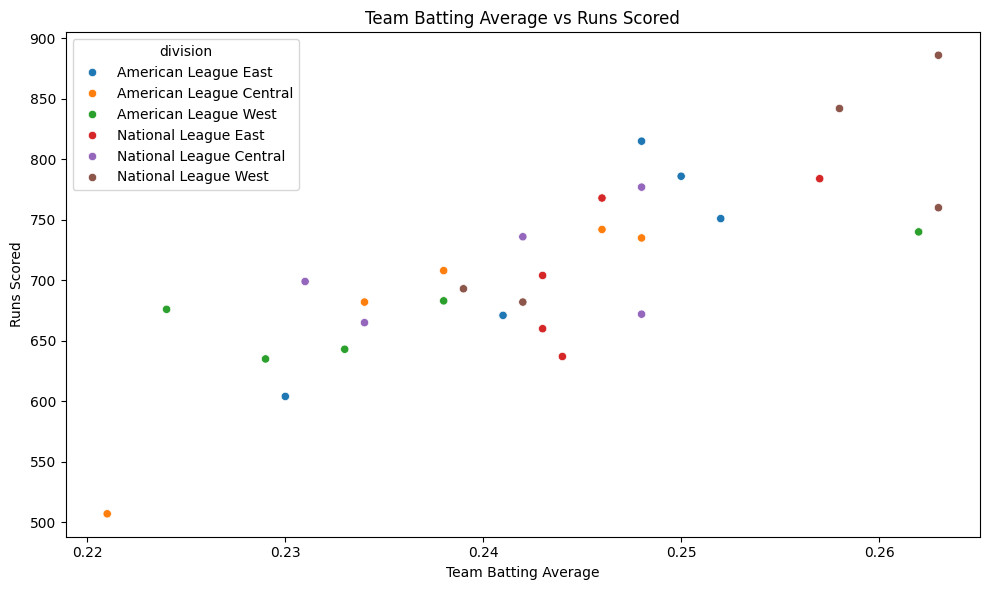

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_offensive, x='team_batting_average', y='runs_scored', hue='division')
plt.title('Team Batting Average vs Runs Scored')
plt.xlabel('Team Batting Average')
plt.ylabel('Runs Scored')
plt.tight_layout()
plt.show()

In [39]:
recent_defensive_stats = defensive_stats_df.sort_values('date').groupby('team_id').last().reset_index()
merged_defensive = pd.merge(teams_df, recent_defensive_stats, left_on='id', right_on='team_id')

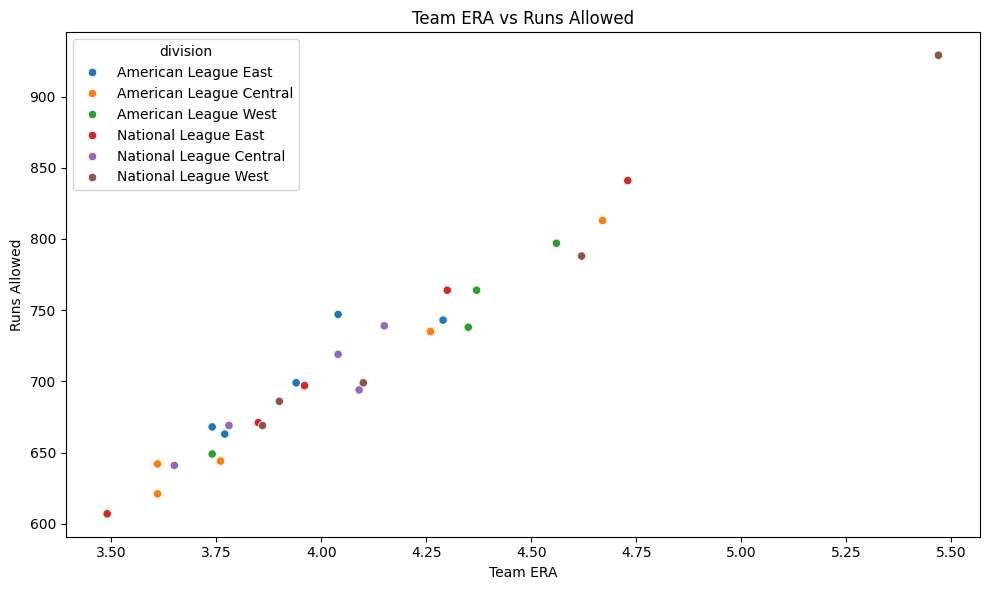

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_defensive, x='team_era', y='runs_allowed', hue='division')
plt.title('Team ERA vs Runs Allowed')
plt.xlabel('Team ERA')
plt.ylabel('Runs Allowed')
plt.tight_layout()
plt.show()